# A comparative analysis of machine learning algorithms for classifying credit card holders as defaulters.

In [229]:
# Importing all the required libraries 
#!pip install imbalanced-learn
#!pip install --upgrade imbalanced-learn

#!pip install xlrd

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,  StandardScaler
import time
from sklearn.decomposition import PCA
from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, GridSearchCV



In [2]:
# Importing the dataset 'default of credit card clients.xls'

data = pd.read_excel('default of credit card clients.xls', skiprows=1,
                     names= ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'REP_SEP',
                            'REP_AUG', 'REP_JUL', 'REP_JUN', 'REP_MAY', 'REP_APR', 'BILL_SEP', 'BILL_AUG',
                            'BILL_JUL', 'BILL_JUN', 'BILL_MAY', 'BILL_APR', 'PAID_SEP', 'PAID_AUG', 'PAID_JUL', 
                            'PAID_JUN', 'PAID_MAY', 'PAID_APR', 'DEFAULT'])


columns_to_convert = ['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'REP_SEP',
                            'REP_AUG', 'REP_JUL', 'REP_JUN', 'REP_MAY', 'REP_APR', 'BILL_SEP', 'BILL_AUG',
                            'BILL_JUL', 'BILL_JUN', 'BILL_MAY', 'BILL_APR', 'PAID_SEP', 'PAID_AUG', 'PAID_JUL', 
                            'PAID_JUN', 'PAID_MAY', 'PAID_APR', 'DEFAULT']

# Convert each column to the desired data type
for column in columns_to_convert:
    data[column] = data[column].astype(int)



In [3]:
# Removed the first row (containing redundant column information) and the first column which is the 'ID'
credit_defaulter = data.drop(columns=['ID'])


# Display dataset dimension
print(f'dataset dimension: {credit_defaulter.shape}')
print(credit_defaulter.columns)
credit_defaulter.head(3)

dataset dimension: (30000, 24)
Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'REP_SEP',
       'REP_AUG', 'REP_JUL', 'REP_JUN', 'REP_MAY', 'REP_APR', 'BILL_SEP',
       'BILL_AUG', 'BILL_JUL', 'BILL_JUN', 'BILL_MAY', 'BILL_APR', 'PAID_SEP',
       'PAID_AUG', 'PAID_JUL', 'PAID_JUN', 'PAID_MAY', 'PAID_APR', 'DEFAULT'],
      dtype='object')


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,REP_SEP,REP_AUG,REP_JUL,REP_JUN,REP_MAY,...,BILL_JUN,BILL_MAY,BILL_APR,PAID_SEP,PAID_AUG,PAID_JUL,PAID_JUN,PAID_MAY,PAID_APR,DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0


In [4]:
# Description of dataset.

credit_defaulter.describe()


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,REP_SEP,REP_AUG,REP_JUL,REP_JUN,REP_MAY,...,BILL_JUN,BILL_MAY,BILL_APR,PAID_SEP,PAID_AUG,PAID_JUL,PAID_JUN,PAID_MAY,PAID_APR,DEFAULT
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [5]:
# Checking the dataset information.

credit_defaulter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   LIMIT_BAL  30000 non-null  int32
 1   SEX        30000 non-null  int32
 2   EDUCATION  30000 non-null  int32
 3   MARRIAGE   30000 non-null  int32
 4   AGE        30000 non-null  int32
 5   REP_SEP    30000 non-null  int32
 6   REP_AUG    30000 non-null  int32
 7   REP_JUL    30000 non-null  int32
 8   REP_JUN    30000 non-null  int32
 9   REP_MAY    30000 non-null  int32
 10  REP_APR    30000 non-null  int32
 11  BILL_SEP   30000 non-null  int32
 12  BILL_AUG   30000 non-null  int32
 13  BILL_JUL   30000 non-null  int32
 14  BILL_JUN   30000 non-null  int32
 15  BILL_MAY   30000 non-null  int32
 16  BILL_APR   30000 non-null  int32
 17  PAID_SEP   30000 non-null  int32
 18  PAID_AUG   30000 non-null  int32
 19  PAID_JUL   30000 non-null  int32
 20  PAID_JUN   30000 non-null  int32
 21  PAID_MAY   3

In [6]:
# Verifying NULL or missing values in the dataset
credit_defaulter.isnull().sum()

LIMIT_BAL    0
SEX          0
EDUCATION    0
MARRIAGE     0
AGE          0
REP_SEP      0
REP_AUG      0
REP_JUL      0
REP_JUN      0
REP_MAY      0
REP_APR      0
BILL_SEP     0
BILL_AUG     0
BILL_JUL     0
BILL_JUN     0
BILL_MAY     0
BILL_APR     0
PAID_SEP     0
PAID_AUG     0
PAID_JUL     0
PAID_JUN     0
PAID_MAY     0
PAID_APR     0
DEFAULT      0
dtype: int64

In [7]:
# Checking the unique values of each column to validate the information about the range of values for each feature.
columns = credit_defaulter[['SEX', 'EDUCATION', 'MARRIAGE', 'REP_SEP', 'REP_AUG', 
                            'REP_JUL', 'REP_JUN', 'REP_MAY', 'REP_APR', 'DEFAULT']]
for i in columns:
    print(f'{i}: {credit_defaulter[i].unique()}')


SEX: [2 1]
EDUCATION: [2 1 3 5 4 6 0]
MARRIAGE: [1 2 3 0]
REP_SEP: [ 2 -1  0 -2  1  3  4  8  7  5  6]
REP_AUG: [ 2  0 -1 -2  3  5  7  4  1  6  8]
REP_JUL: [-1  0  2 -2  3  4  6  7  1  5  8]
REP_JUN: [-1  0 -2  2  3  4  5  7  6  1  8]
REP_MAY: [-2  0 -1  2  3  5  4  7  8  6]
REP_APR: [-2  2  0 -1  3  6  4  7  8  5]
DEFAULT: [1 0]


In [8]:
# mapping the values

mapping1 = {0: 4, 5: 4, 6: 4}
credit_defaulter['EDUCATION'] = credit_defaulter['EDUCATION'].replace(mapping1)

mapping2 = {0: 3}
credit_defaulter['MARRIAGE'] = credit_defaulter['MARRIAGE'].replace(mapping2)

mapping3 = {-1: 0, -2: 0}
cols_replace = ['REP_SEP', 'REP_AUG', 'REP_JUL', 'REP_JUN', 'REP_MAY', 'REP_APR']
credit_defaulter[cols_replace] = credit_defaulter[cols_replace].replace(mapping3)

columns = credit_defaulter[['SEX', 'EDUCATION', 'MARRIAGE', 'REP_SEP', 'REP_AUG', 
                            'REP_JUL', 'REP_JUN', 'REP_MAY', 'REP_APR', 'DEFAULT']]
for i in columns:
    print(f'{i}: {credit_defaulter[i].unique()}')


SEX: [2 1]
EDUCATION: [2 1 3 4]
MARRIAGE: [1 2 3]
REP_SEP: [2 0 1 3 4 8 7 5 6]
REP_AUG: [2 0 3 5 7 4 1 6 8]
REP_JUL: [0 2 3 4 6 7 1 5 8]
REP_JUN: [0 2 3 4 5 7 6 1 8]
REP_MAY: [0 2 3 5 4 7 8 6]
REP_APR: [0 2 3 6 4 7 8 5]
DEFAULT: [1 0]


In [10]:
credit_defaulter.shape

(30000, 24)

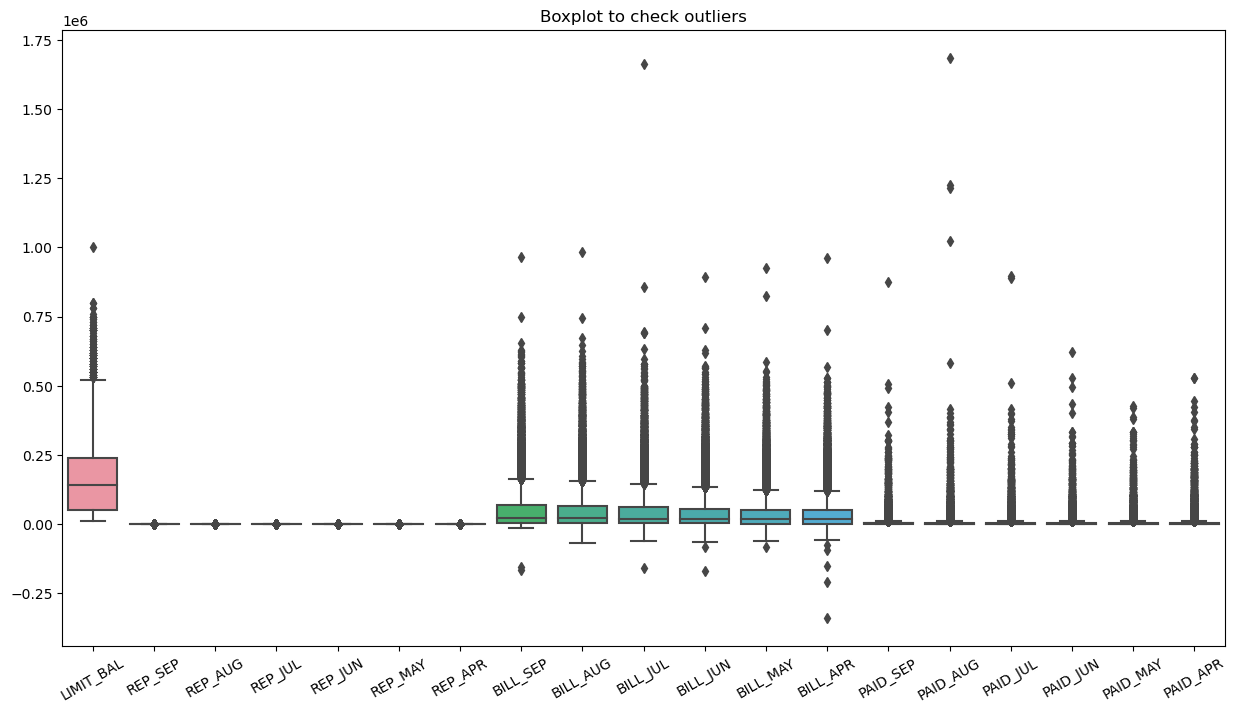

In [12]:
# Checking for outliers among the non categorical variables

features = ['LIMIT_BAL', 'REP_SEP', 'REP_AUG', 'REP_JUL', 'REP_JUN', 'REP_MAY', 'REP_APR', 
            'BILL_SEP', 'BILL_AUG', 'BILL_JUL', 'BILL_JUN', 'BILL_MAY', 'BILL_APR', 
            'PAID_SEP', 'PAID_AUG', 'PAID_JUL', 'PAID_JUN', 'PAID_MAY', 'PAID_APR']




plt.figure(figsize=(15, 8))
sns.boxplot(data=credit_defaulter[features])
plt.title('Boxplot to check outliers')
plt.xticks(rotation=30)
plt.show()

plt.show()

In [13]:
# splitting the dataset into train(80%) and test(20%) data:
# x = features,  y = target

from sklearn.model_selection import train_test_split

x = credit_defaulter.drop('DEFAULT', axis = 1)
y = credit_defaulter['DEFAULT']
x_train, x_test, y_train, y_test=train_test_split(x,y,train_size=0.8, random_state=42)

print(f'Number of smaples in train set : (features,target)  = {len(x_train),len(y_train)}')
print(f'Number of smaples in test set : (features,target)  = {len(x_test),len(y_test)}')
#print(x_train.info())
#print(x_train.head(2))
#print(x_test.head(2))

Number of smaples in train set : (features,target)  = (24000, 24000)
Number of smaples in test set : (features,target)  = (6000, 6000)


# FEATURE SCALING - Using Standardization and Normalization

In [96]:
# Standardization using StandardScaler
from sklearn.preprocessing import MinMaxScaler,  StandardScaler
std_scalar = StandardScaler()

x_train_std_scaled = std_scalar.fit_transform(x_train)
x_test_std_scaled = std_scalar.transform(x_test)

# Normalization using MinMaxScaler
mm_scalar = MinMaxScaler()

x_train_mm_scaled = mm_scalar.fit_transform(x_train)
x_test_mm_scaled = mm_scalar.transform(x_test)

print('Scalled x_train using Standardisation: ', x_train_std_scaled)
print('Scalled x_train using MinMax: ', x_train_mm_scaled)


Scalled x_train using Standardisation:  [[-0.67235902  0.80815856  0.21090022 ... -0.22465419 -0.21600791
  -0.24524018]
 [-1.05776818 -1.23738094  0.21090022 ... -0.24078483 -0.30852284
  -0.29553162]
 [ 0.0984593   0.80815856  2.89325603 ...  0.12267581  0.35348711
  -0.28510675]
 ...
 [-0.90360452 -1.23738094 -1.13027768 ... -0.29935805 -0.30852284
  -0.29553162]
 [-0.74944086  0.80815856  0.21090022 ... -0.22575819 -0.30852284
  -0.22679617]
 [-0.05570437  0.80815856  0.21090022 ... -0.19815824  0.60062042
  -0.20961231]]
Scalled x_train using MinMax:  [[7.07070707e-02 1.00000000e+00 3.33333333e-01 ... 1.96135266e-03
  3.38781185e-03 1.66558220e-03]
 [2.02020202e-02 0.00000000e+00 3.33333333e-01 ... 1.53784219e-03
  0.00000000e+00 0.00000000e+00]
 [1.71717172e-01 1.00000000e+00 1.00000000e+00 ... 1.10805153e-02
  2.42421969e-02 3.45257359e-04]
 ...
 [4.04040404e-02 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [6.06060606e-02 1.00000000e+00 3.33

# Correlation between all the variables including target

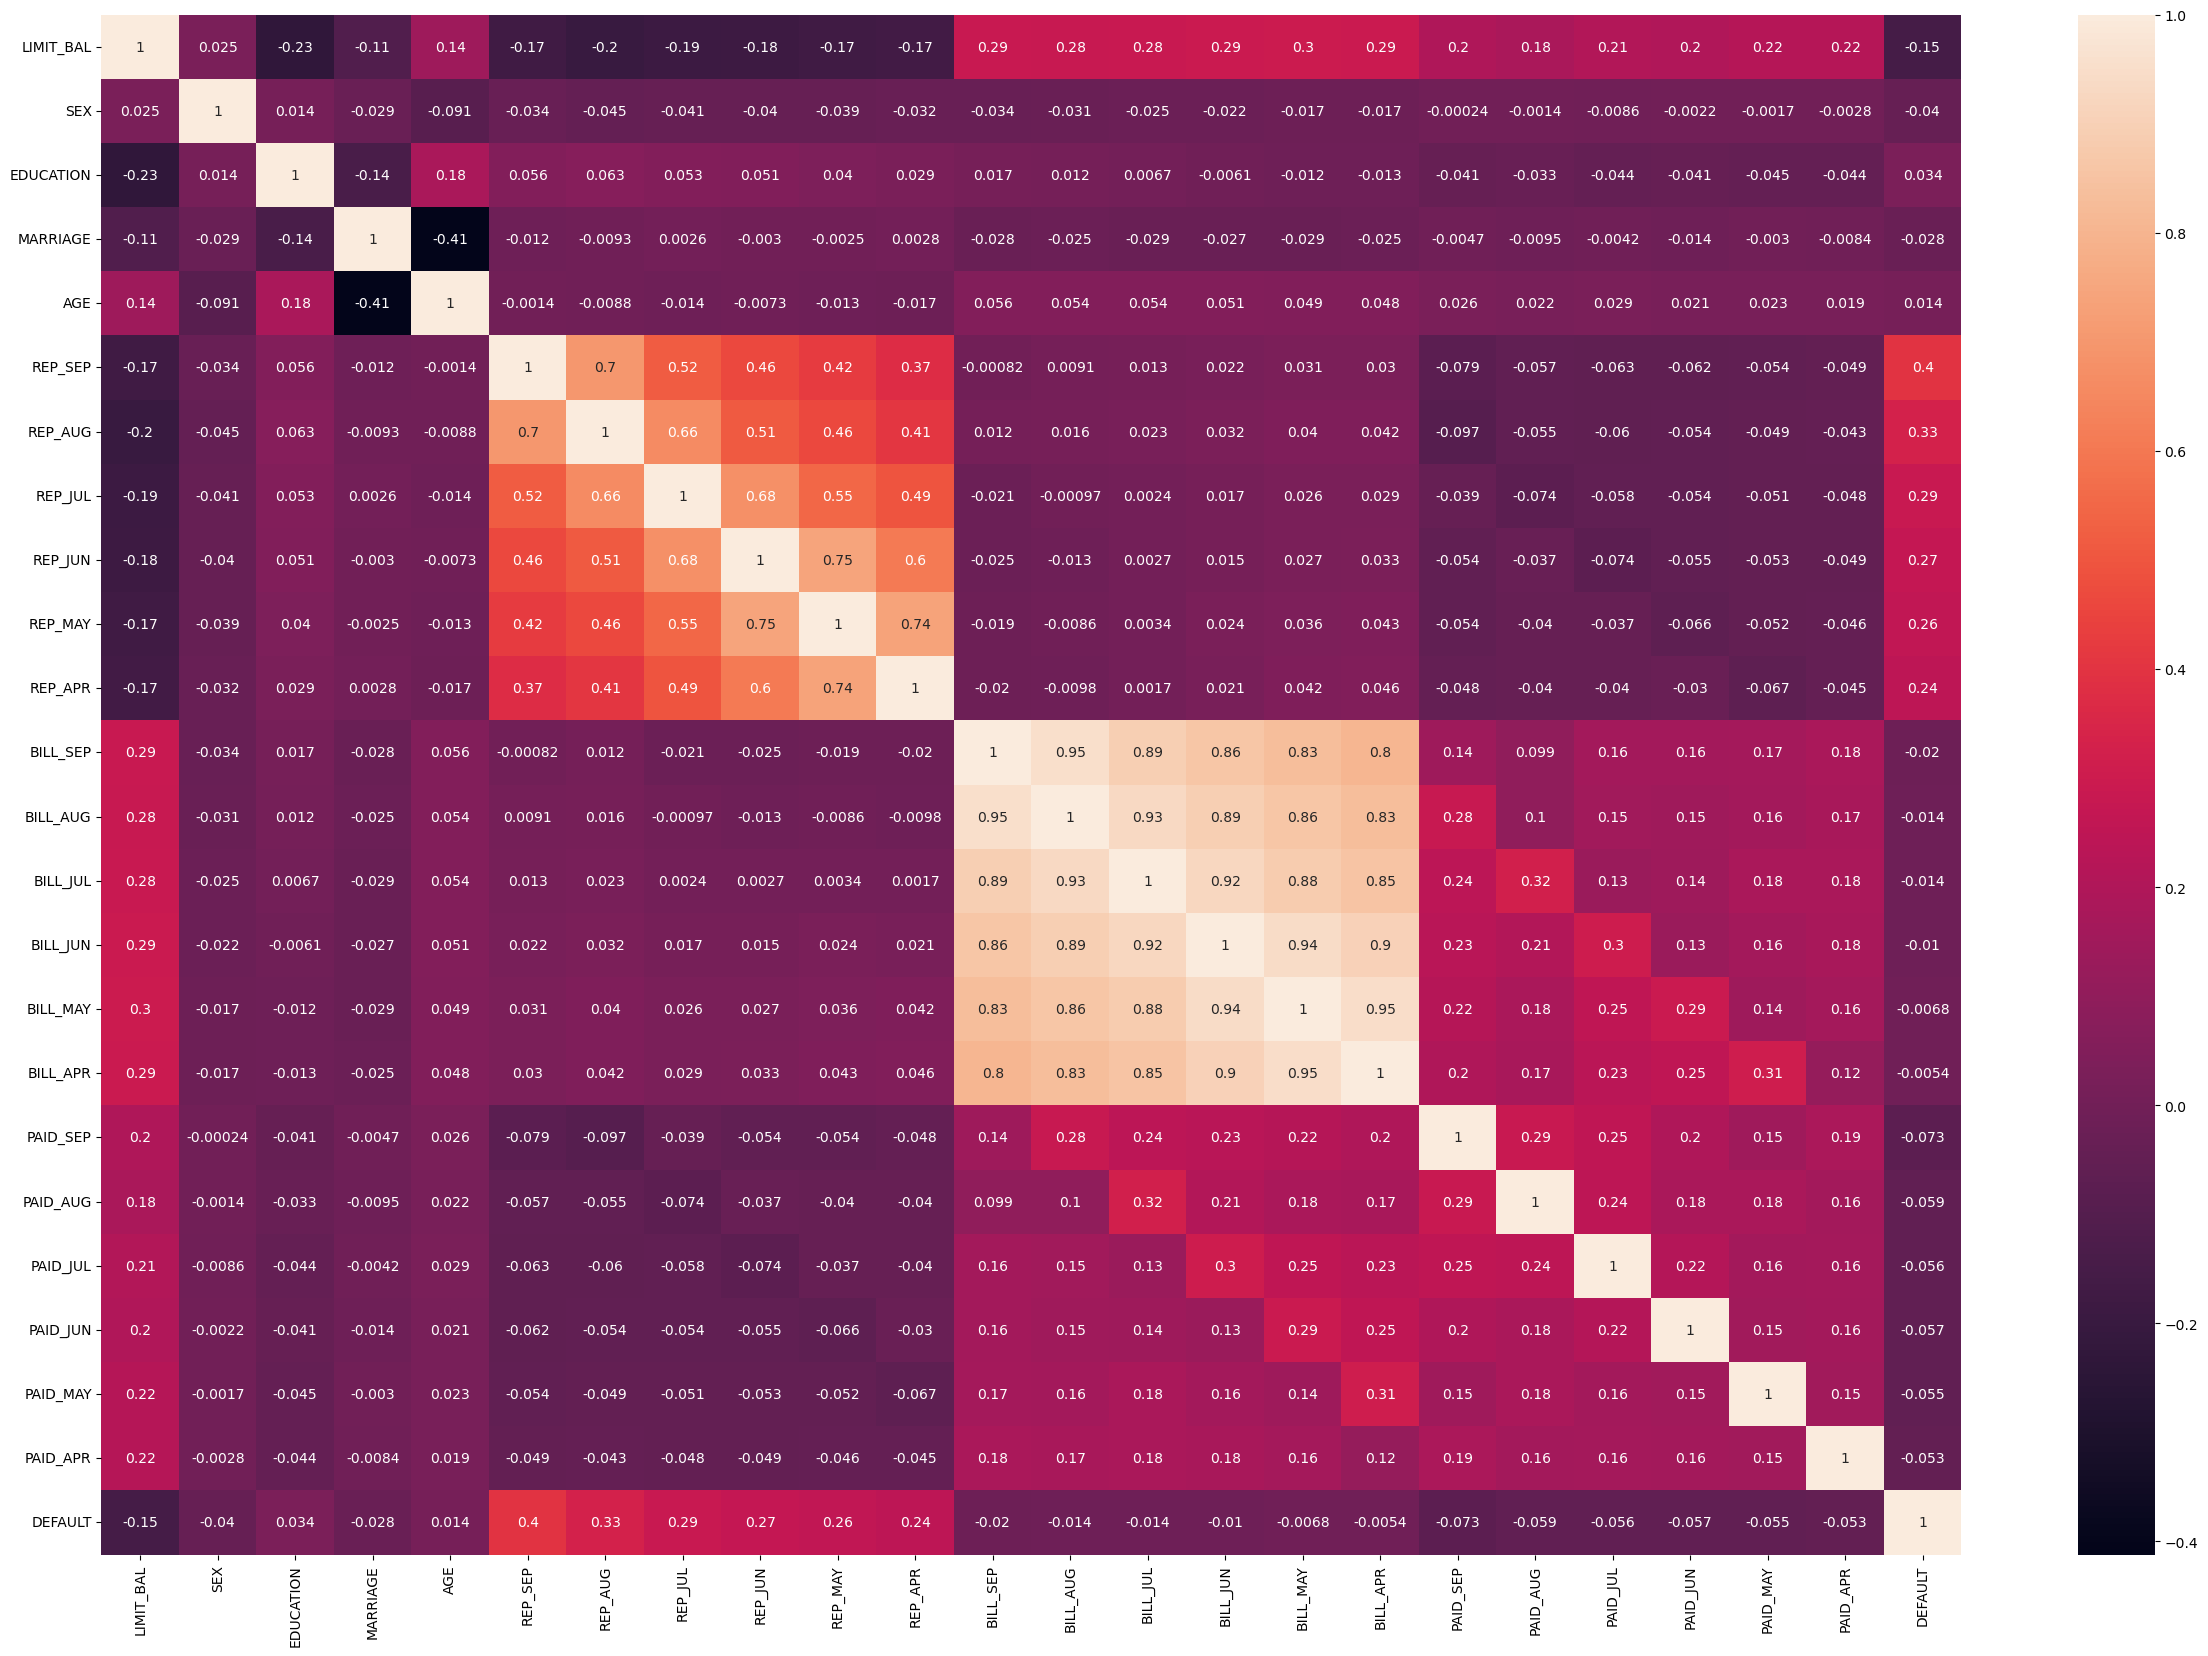

In [101]:
# Finding the correlation between the features including target
import seaborn as sns
plt.subplots(figsize=(30,20))
sns.heatmap(credit_defaulter.corr(), annot=True)
plt.show()

# FEATURE EXTRACTION USING PCA - Dimentionality reduction

pca.explained_variance_ratio_ [0.60699934 0.29536756 0.03105447 0.01836374 0.01001359 0.0095098
 0.00761755 0.00662335]
pca.n_components_ 8


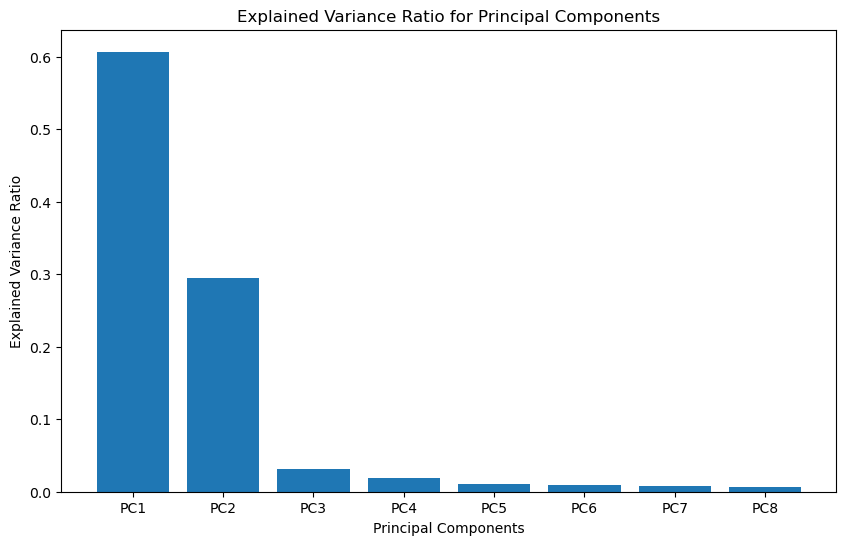

pca.explained_variance_ratio_ [0.25716069 0.17058119 0.07309907 0.06574071 0.04641618 0.04399156
 0.04145067 0.03870536 0.03805897 0.03793096 0.03375593 0.03060667
 0.02615776 0.02317457 0.02111661 0.0146852  0.01140634 0.01068479]
pca.n_components_ 18


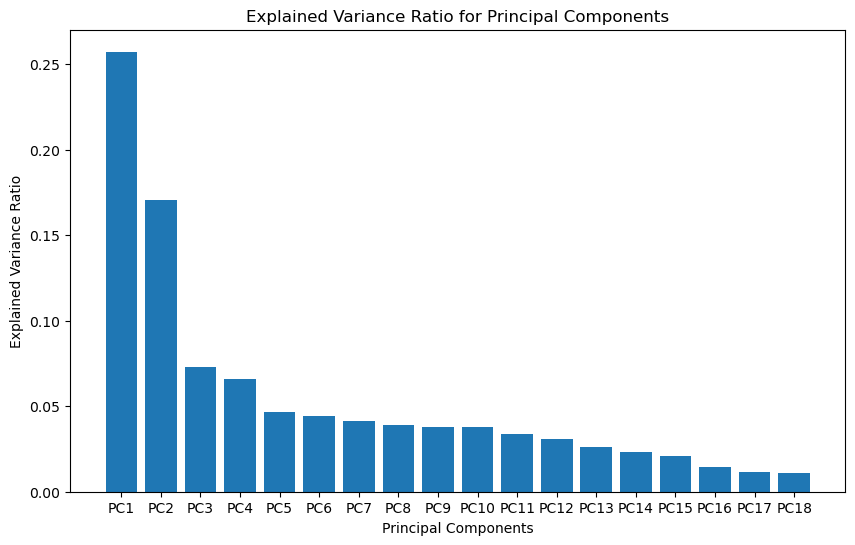

pca.explained_variance_ratio_ [0.48912535 0.16384252 0.11977989 0.0710423  0.0460369  0.03679305
 0.0212533  0.01704626 0.00909354 0.00616504]
pca.n_components_ 10


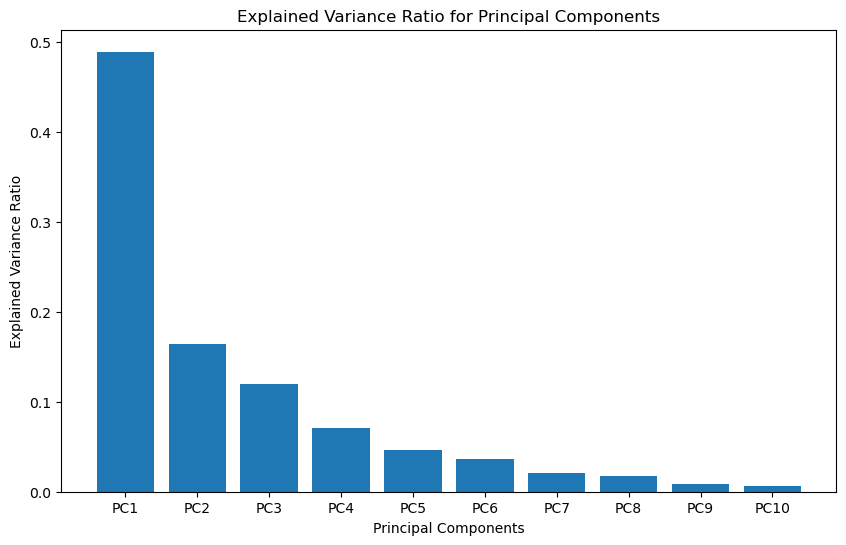

In [106]:
pca = PCA(0.98)

# PCA on standardized train data
x_train_std_pca = pca.fit_transform(x_train_std_scaled)
x_test_std_pca = pca.transform(x_test_std_scaled)

# PCA on normalized train data
x_train_mm_pca = pca.fit_transform(x_train_mm_scaled)
x_test_mm_pca = pca.transform(x_test_mm_scaled)

# Function to check the number of PCA components, with >98% information on unscaled, standardized and normalized train set:

def PCA_comp(x_tr):
    pca= PCA(0.98)
    x_train_pca = pca.fit_transform(x_tr)
    print('pca.explained_variance_ratio_', pca.explained_variance_ratio_)
    print('pca.n_components_', pca.n_components_)

    pc_values = range(1, pca.n_components_ + 1)

    plt.figure(figsize=(10, 6))
    plt.bar(pc_values, pca.explained_variance_ratio_, )
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio for Principal Components')
    plt.xticks(pc_values, ['PC{}'.format(i) for i in pc_values])
    plt.show()
    

PCA_comp(x_train)
PCA_comp(x_train_std_scaled)
PCA_comp(x_train_mm_scaled)


# FEATURE IMPORTANCE

0.9999999999999998


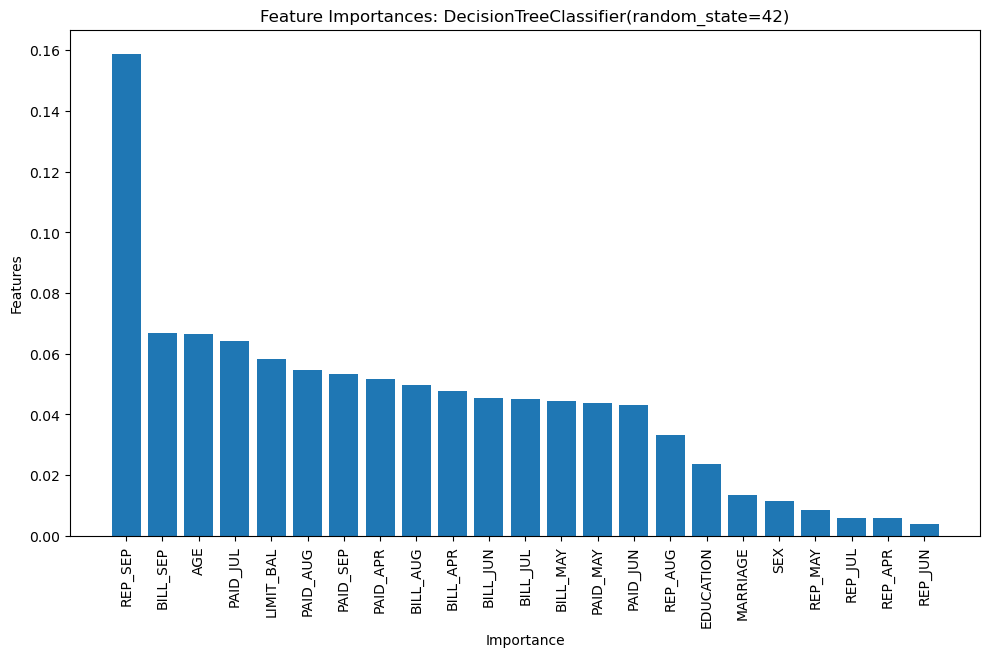

1.0


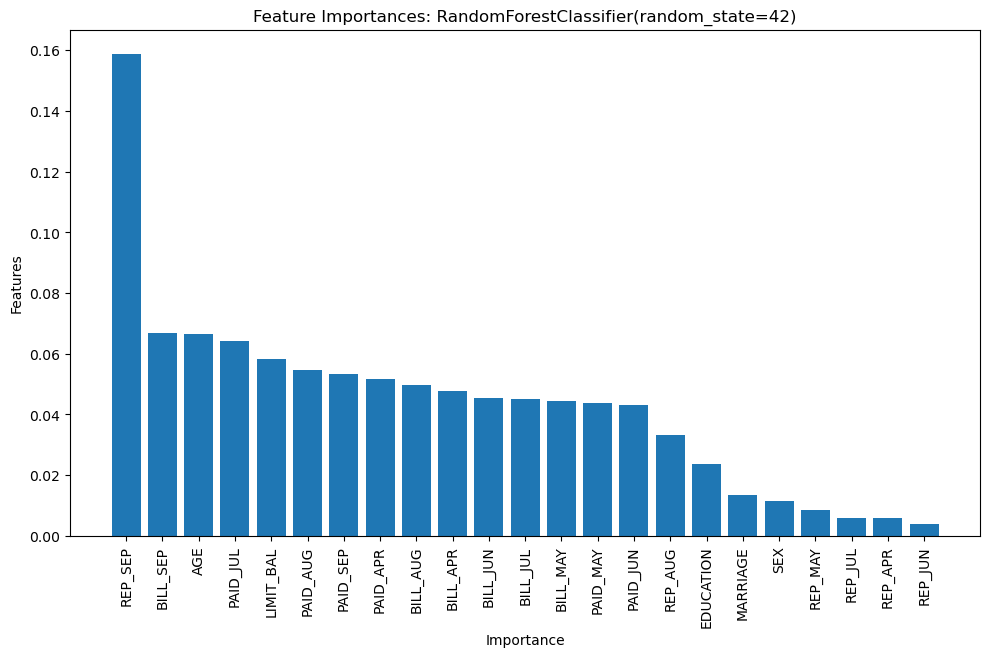

In [164]:
# Feature importance 

def feature_importance(model):
    if model in {DecisionTreeClassifier, RandomForestClassifier}:
        clf = model(random_state=42)
    else:
        clf = model()

    clf.fit(x_train, y_train)
    print(clf.feature_importances_.sum())
    feature_importances = tree.feature_importances_
    importance_df = pd.DataFrame({'Feature': x_train.columns, 'Importance': feature_importances})
    importance_df_sorted = importance_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.bar(importance_df_sorted['Feature'], importance_df_sorted['Importance'])
    plt.xlabel('Importance')
    plt.ylabel('Features')
    plt.title(f'Feature Importances: {clf}')
    plt.tight_layout()
    plt.xticks(rotation=90) 
    plt.show()


feature_importance(DecisionTreeClassifier)
feature_importance(RandomForestClassifier)


# CLASS IMBALANCE 

DEFAULT
0    23364
1     6636
Name: count, dtype: int64
percentage of defaulter: 22.12%
percentage of non-defaulter: 77.88000000000001%


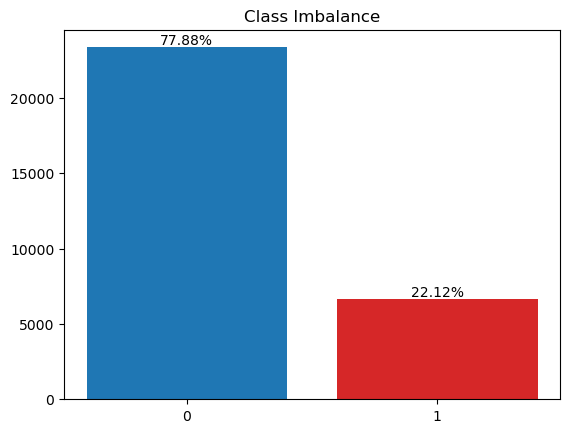

In [165]:
# Checking for class imbalance by displaying the count for each class in the target variable 'DEFAULT' 

classes = credit_defaulter['DEFAULT'].value_counts()
print(classes)
print(f'percentage of defaulter: {(classes[1]/30000)*100}%')
print(f'percentage of non-defaulter: {(classes[0]/30000)*100}%')

# Pictorial represenation

plt.figure()
bars = plt.bar(classes.index, classes.values, color=['tab:BLUE', 'tab:RED'])
plt.xticks([0, 1])
plt.title('Class Imbalance')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height/sum(classes.values)*100:.2f}%', 
             ha='center', va='bottom')

plt.show()



# SMOTE - Oversampling to balance the class in the dataset

In [173]:
# Using SMOET - Oversampling to rectify class imbalance

t0 = time()
smote = SMOTE(random_state=42)
x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
x_train_std_pca_smote, y_train_std_pca_smote = smote.fit_resample(x_train_std_pca, y_train)  #y_train was not scaled and no PCA
x_train_mm_pca_smote, y_train_mm_pca_smote = smote.fit_resample(x_train_mm_pca, y_train)     #y_train was not scaled and no PCA


print(f' Size of calsses before SMOTE: {Counter(y_train)}')

print('***********Unscaled training set***********')
print(f' Size of calsses after SMOTE: {Counter(y_train_smote)}')

print('***********StandardScalar training set***********')
print(f' Size of calsses after SMOTE: {Counter(y_train_std_pca_smote)}')

print('***********MinMaxScalar training set***********')
print(f' Size of calsses after SMOTE: {Counter(y_train_mm_pca_smote)}')

print("done in %0.3fs" % (time() - t0))


 Size of calsses before SMOTE: Counter({0: 18677, 1: 5323})
***********Unscaled training set***********
 Size of calsses after SMOTE: Counter({0: 18677, 1: 18677})
***********StandardScalar training set***********
 Size of calsses after SMOTE: Counter({0: 18677, 1: 18677})
***********MinMaxScalar training set***********
 Size of calsses after SMOTE: Counter({0: 18677, 1: 18677})
done in 1.374s


# CLASSIFIERS WITH TRAINING AND TESTING SET - No scaling, No PCA, No SMOTE resampling

*********************DecisionTreeClassifier(random_state=4)*********************
Accuracy on train data for DecisionTreeClassifier(random_state=4): 0.999
Accuracy on test data for DecisionTreeClassifier(random_state=4): 0.724
Classification report: 
 ,               precision    recall  f1-score   support

  No Default       0.83      0.81      0.82      4687
     Default       0.38      0.40      0.39      1313

    accuracy                           0.72      6000
   macro avg       0.60      0.61      0.60      6000
weighted avg       0.73      0.72      0.73      6000

Confusion matrix:
[[3814  873]
 [ 786  527]]


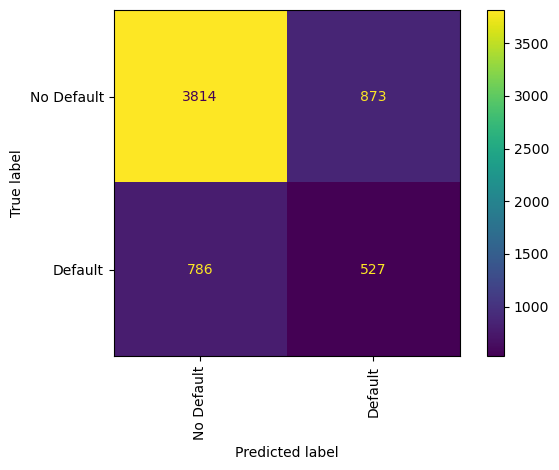

AUC Score for DecisionTreeClassifier(random_state=4): 0.608


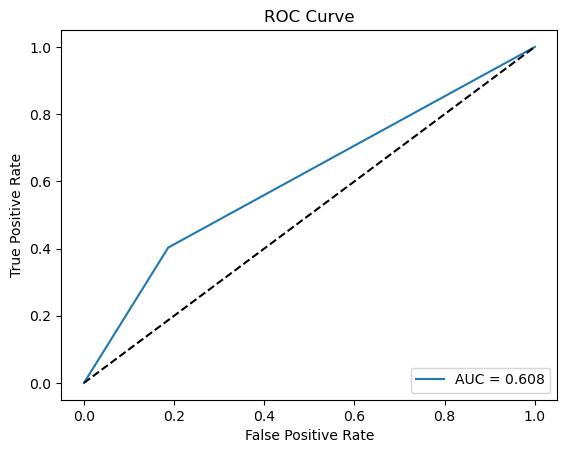

*********************KNeighborsClassifier()*********************
Accuracy on train data for KNeighborsClassifier(): 0.816
Accuracy on test data for KNeighborsClassifier(): 0.756
Classification report: 
 ,               precision    recall  f1-score   support

  No Default       0.80      0.92      0.85      4687
     Default       0.38      0.19      0.25      1313

    accuracy                           0.76      6000
   macro avg       0.59      0.55      0.55      6000
weighted avg       0.71      0.76      0.72      6000

Confusion matrix:
[[4290  397]
 [1069  244]]


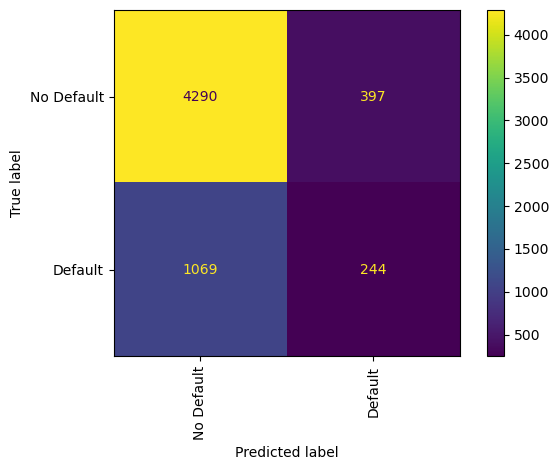

AUC Score for KNeighborsClassifier(): 0.607


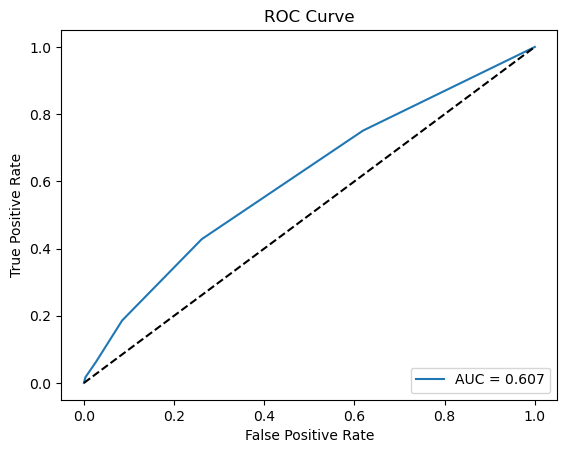

*********************LogisticRegression(random_state=4)*********************
Accuracy on train data for LogisticRegression(random_state=4): 0.778
Accuracy on test data for LogisticRegression(random_state=4): 0.781
Classification report: 
 ,               precision    recall  f1-score   support

  No Default       0.78      1.00      0.88      4687
     Default       1.00      0.00      0.00      1313

    accuracy                           0.78      6000
   macro avg       0.89      0.50      0.44      6000
weighted avg       0.83      0.78      0.69      6000

Confusion matrix:
[[4687    0]
 [1312    1]]


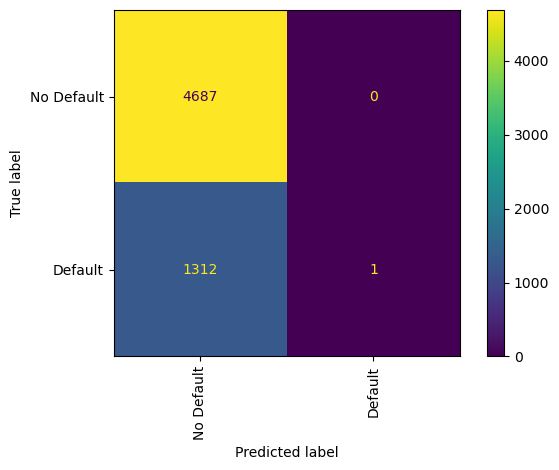

AUC Score for LogisticRegression(random_state=4): 0.659


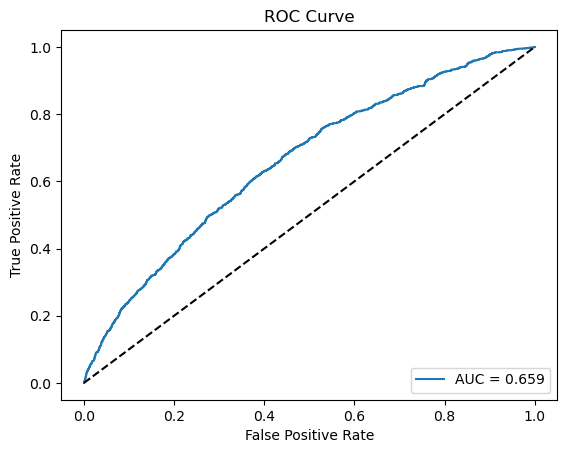

In [182]:
def class_raw_split(model):
    if model in {DecisionTreeClassifier, LogisticRegression}:
        clf = model(random_state=4)
    else:
        clf = model()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    
    print(f'*********************{clf}*********************')
    print(f'Accuracy on train data for {clf}: {clf.score(x_train, y_train):.3f}')
    print(f'Accuracy on test data for {clf}: {clf.score(x_test, y_test):.3f}')
    target = ['No Default', 'Default']
    print(f'Classification report: \n , {classification_report(y_test, y_pred, target_names=target, zero_division=1)}')
    confusion = confusion_matrix(y_test, y_pred)
    print(f'Confusion matrix:\n{confusion}')
    ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test, display_labels=target, xticks_rotation="vertical")
    plt.tight_layout()
    plt.show()
# calculate roc_auc_score
    auc_score = roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1])
    print(f'AUC Score for {clf}: {auc_score:.3f}')
    
# Plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(x_test)[:, 1])
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    
class_raw_split(DecisionTreeClassifier)
class_raw_split(KNeighborsClassifier)
class_raw_split(LogisticRegression)

    


# CLASSIFIERS WITH TRAINING AND TESTING SET - StandardScalar scaling, PCA and SMOTE resampling

In [204]:
def class_smote_split(model, x_tr, x_ts, y_tr):
    x_train = x_tr
    x_test = x_ts
    y_train = y_tr
    if model in {DecisionTreeClassifier, LogisticRegression}:
        clf = model(random_state=42)
    else:
        clf = model()

    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    
    print(f'*********************{clf}*********************')
    print(f'Accuracy : {accuracy_score(y_test, y_pred)}')
    print(f'Accuracy on train data for {clf}: {clf.score(x_train, y_train):.3f}')
    print(f'Accuracy on test data for {clf}: {clf.score(x_test, y_test):.3f}')
    target = ['No Default', 'Default']
    print(f'Classification report: \n , {classification_report(y_test, y_pred, target_names=target, zero_division=1)}')
    confusion = confusion_matrix(y_test, y_pred)
    print(f'Confusion matrix:\n{confusion}')
# calculate roc_auc_score
    auc_score = roc_auc_score(y_test, clf.predict_proba(x_test)[:, 1])
    print(f'AUC Score for {clf}: {auc_score:.3f}')
    
# Decision tree 
class_smote_split(DecisionTreeClassifier, x_train_std_pca_smote, x_test_std_pca, y_train_std_pca_smote )
class_smote_split(DecisionTreeClassifier, x_train_mm_pca_smote, x_test_mm_pca, y_train_mm_pca_smote)


# KNN
class_smote_split(KNeighborsClassifier, x_train_std_pca_smote, x_test_std_pca, y_train_std_pca_smote)
class_smote_split(KNeighborsClassifier, x_train_mm_pca_smote, x_test_mm_pca, y_train_mm_pca_smote)


# LR
class_smote_split(LogisticRegression, x_train_std_pca_smote, x_test_std_pca, y_train_std_pca_smote)
class_smote_split(LogisticRegression, x_train_mm_pca_smote, x_test_mm_pca, y_train_mm_pca_smote)


*********************DecisionTreeClassifier(random_state=42)*********************
Accuracy : 0.6923333333333334
Accuracy on train data for DecisionTreeClassifier(random_state=42): 1.000
Accuracy on test data for DecisionTreeClassifier(random_state=42): 0.692
Classification report: 
 ,               precision    recall  f1-score   support

  No Default       0.84      0.75      0.79      4687
     Default       0.35      0.48      0.41      1313

    accuracy                           0.69      6000
   macro avg       0.59      0.62      0.60      6000
weighted avg       0.73      0.69      0.71      6000

Confusion matrix:
[[3524 1163]
 [ 683  630]]
AUC Score for DecisionTreeClassifier(random_state=42): 0.616
*********************DecisionTreeClassifier(random_state=42)*********************
Accuracy : 0.6835
Accuracy on train data for DecisionTreeClassifier(random_state=42): 1.000
Accuracy on test data for DecisionTreeClassifier(random_state=42): 0.683
Classification report: 
 ,        

In [ ]:
# 

# Decision tree with different depths

max_depth values ranging from 2 to 8:
Accuracy on training set: ['0.820', '0.822', '0.823', '0.825', '0.827', '0.830', '0.836', '0.841']
Accuracy on test set: ['0.819', '0.821', '0.821', '0.819', '0.820', '0.817', '0.813', '0.813']


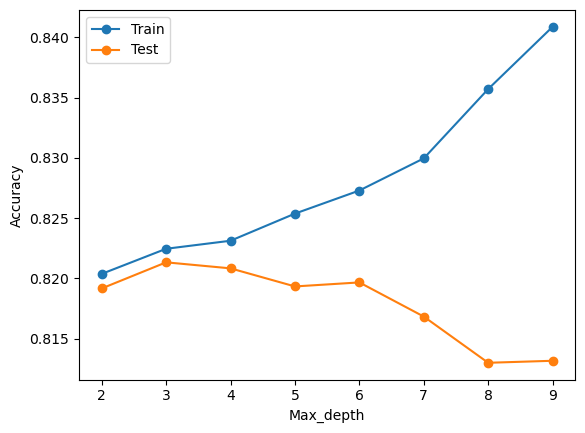

In [19]:
# Decision tree with different depths:
train_acc=[]
test_acc=[]
max_depth=[]

for i in range(2,10):
    tree=DecisionTreeClassifier(max_depth=i,random_state=42)
    tree.fit(x_train,y_train)
    train_acc.append(tree.score(x_train,y_train))
    test_acc.append(tree.score(x_test,y_test))
    max_depth.append(i)
    
# Plotting the accuracy of test and train set
print('max_depth values ranging from 2 to 8:')
formatted_train_acc = ["{:.3f}".format(acc) for acc in train_acc]
print('Accuracy on training set:',formatted_train_acc)
formatted_test_acc = ["{:.3f}".format(acc) for acc in test_acc]
print('Accuracy on test set:',formatted_test_acc)

plt.figure()
plt.plot(max_depth, train_acc, label='Train',marker='o')
plt.plot(max_depth, test_acc, label='Test', marker='o')
plt.xlabel('Max_depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




# K-NEAREST NEIGHBORS CLASSIFICATION



k values ranging from 3 to 40:
Accuracy on training set: ['0.845', '0.804', '0.800', '0.792', '0.791', '0.789', '0.789', '0.787', '0.785', '0.785', '0.784', '0.783', '0.784']
Accuracy on test set: ['0.737', '0.769', '0.769', '0.775', '0.773', '0.778', '0.779', '0.779', '0.778', '0.781', '0.780', '0.782', '0.781']


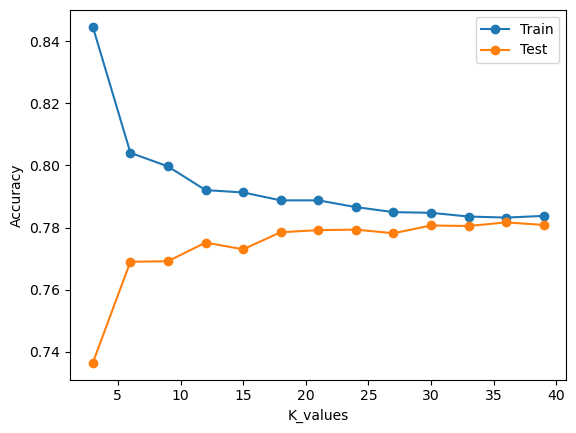

In [203]:
# KNN Different values of K - (5-25)
train_acc_knn=[]
test_acc_knn=[]
k_value=[]

for k in range(3,40, 3):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    train_acc_knn.append(knn.score(x_train,y_train))
    test_acc_knn.append(knn.score(x_test,y_test))
    k_value.append(k)

    
# Plotting the accuracy of test and train set
print('k values ranging from 3 to 40:')
formatted_train_acc_knn = ["{:.3f}".format(acc) for acc in train_acc_knn]
print('Accuracy on training set:',formatted_train_acc_knn)
formatted_test_acc_knn = ["{:.3f}".format(acc) for acc in test_acc_knn]
print('Accuracy on test set:',formatted_test_acc_knn)


plt.figure()
plt.plot(k_value, train_acc_knn, label='Train',marker='o')
plt.plot(k_value, test_acc_knn, label='Test', marker='o')
plt.xlabel('K_values')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Hyperparameter tuning each model using GridSearchCV and applying the result on test data

# Decision tree hyperparameter tuning and testing

In [243]:
# Decision tree classifier:

param = {
    'criterion': ['gini', "entropy"],
    'max_depth': [i for i in range(1, 20, 3)], 
    'min_samples_leaf': [i for i in range(2, 11, 1)], 
    'min_impurity_decrease': [0.1, 0.2, 0.3, 0.4, 0.5]
}
cv = KFold(n_splits= 10, shuffle= True, random_state=42)                  
grid_dt = GridSearchCV(DecisionTreeClassifier(), param_grid=param, cv= cv, n_jobs= -1)
grid_dt.fit(x_train_std_pca_smote, y_train_std_pca_smote)
print('Best DT Classifier:', grid_dt.best_params_, 'Best Accuracy Score:', grid_dt.best_score_)  

Best DT Classifier: {'criterion': 'entropy', 'max_depth': 1, 'min_impurity_decrease': 0.1, 'min_samples_leaf': 2} Best Accuracy Score: 0.6950531103715362


In [248]:
# Using the results to check the accuracy of DT
dt_clf = DecisionTreeClassifier(criterion="entropy", max_depth=1, min_samples_leaf=2, min_impurity_decrease=0.1)
dt_clf.fit(x_train_std_pca_smote, y_train_std_pca_smote)
print("DT's accuracy: %.2f%%" % (100*dt_clf.score(x_test_std_pca, y_test)))

DT's accuracy: 75.92%


# KNN hyperparameter tuning and testing

In [263]:
# KNN

param = {
    'n_neighbors': [i for i in range(1, 50, 5)]
}
cv = KFold(n_splits= 5, shuffle= True, random_state=42)                  
grid_dt = GridSearchCV(KNeighborsClassifier(), param_grid=param, cv= cv, n_jobs= -1)
grid_dt.fit(x_train_std_pca_smote, y_train_std_pca_smote)
print('Best KNN Classifier:', grid_dt.best_params_, 'Best KNN Accuracy Score:', grid_dt.best_score_)

Best KNN Classifier: {'n_neighbors': 1} Best KNN Accuracy Score: 0.8392141680540034


In [265]:
# Using the results to check the accuracy of KNN

knn_clf = KNeighborsClassifier(n_neighbors=1)
knn_clf.fit(x_train_std_pca_smote, y_train_std_pca_smote)
print("KNN's accuracy: %.2f%%" % (100*knn_clf.score(x_test_std_pca, y_test)))

KNN's accuracy: 69.97%


# LR hyperparameter tuning and testing

In [245]:
# Logistic Regression

param = {
    'penalty': ['l1','l2'], 
    'C': [0.1, 0.2, 0.5, 0.7, 1, 5, 10]
}
cv = KFold(n_splits= 5, shuffle= True, random_state=42)                  
grid_dt = GridSearchCV(LogisticRegression(), param_grid=param, cv= cv, n_jobs= -1)
grid_dt.fit(x_train_std_pca_smote, y_train_std_pca_smote)
print('Best LR Classifier:', grid_dt.best_params_, 'Best LR Accuracy Score:', grid_dt.best_score_)  

Best LR Classifier: {'C': 0.1, 'penalty': 'l2'} Best LR Accuracy Score: 0.701371030904504


In [253]:
# Using the results to check the accuracy of LR

logreg_clf = LogisticRegression(penalty='l2', C=0.1)
logreg_clf.fit(x_train_std_pca_smote, y_train_std_pca_smote)
print("LR's accuracy: %.2f%%" % (100*logreg_clf.score(x_test_std_pca, y_test)))

LR's accuracy: 77.67%


In [266]:
# Random Forest
param = {
    'criterion': ['gini', "entropy"], 
    'n_estimators': [i for i in range(200, 1001, 200)], 
}
                         
cv = KFold(n_splits= 5, shuffle= True, random_state=42)                  
grid_dt = GridSearchCV(RandomForestClassifier(), param_grid=param, cv= cv, n_jobs= -1)
grid_dt.fit(x_train_std_pca_smote, y_train_std_pca_smote)
print('Best RF Classifier:', grid_dt.best_params_, 'Best RF Accuracy Score:', grid_dt.best_score_)  

Best RF Classifier: {'criterion': 'gini', 'n_estimators': 800} Best RF Accuracy Score: 0.8517966391062846


In [267]:
# Using the results to check the accuracy of RF

rf_clf = RandomForestClassifier(criterion='gini', n_estimators=800)
rf_clf.fit(x_train_std_pca_smote, y_train_std_pca_smote)
print("LR's accuracy: %.2f%%" % (100*rf_clf.score(x_test_std_pca, y_test)))

LR's accuracy: 77.90%


# TIME TAKEN BY EACH MODEL IN CALCULATING THE ACCURACY USING TESTING AND TRAINING DATA - WITH AND WITHOUT SMOTE

In [234]:
# Time for each model in calculating the accuracy using unscaled and SMOTE scaled 

def mode_time(x_tr, y_tr):
    x_train = x_tr
    y_train = y_tr
    clf1 = DecisionTreeClassifier(random_state=42)
    clf2 = KNeighborsClassifier()
    clf3 = LogisticRegression(random_state=42)
    clf4 = RandomForestClassifier(random_state=42)


    for clf, label in zip([clf1, clf2, clf3, clf4], 
                          ['Decision Tree', 'KNN','Logistic Regression', 'RandomForestClassifier']):
        start = time.time()
        scores = cross_val_score(clf, x_train, y_train, scoring='accuracy', cv=5)
        end = time.time()
        running_time = end - start
        
        print("Accuracy: %0.8f (+/- %0.2f), time elapsed %0.2f seconds. Model Name[%s]" %
              (scores.mean(), scores.std(), running_time, label))

print('module time using unscaled x_train,y_train')   
mode_time(x_train, y_train)

print('module time using unscaled but SMOTE resampled x_train_smote,y_train_smote')   
mode_time(x_train_smote, y_train_smote)

print('module time using StandardScalar and SMOTE resampled x_train_std_pca_smote,y_train_std_pca_smote')   
mode_time(x_train_std_pca_smote, y_train_std_pca_smote)

print('module time using MinMaxScalar and SMOTE resamples x_train_mm_pca_smote,y_train_mm_pca_smote')   
mode_time(x_train_mm_pca_smote, y_train_mm_pca_smote)

    

module time using unscaled x_train,y_train
Accuracy: 0.72670833 (+/- 0.01), time elapsed 4.77 seconds. Model Name[Decision Tree]
Accuracy: 0.75308333 (+/- 0.00), time elapsed 20.12 seconds. Model Name[KNN]
Accuracy: 0.77812500 (+/- 0.00), time elapsed 1.51 seconds. Model Name[Logistic Regression]
Accuracy: 0.81600000 (+/- 0.01), time elapsed 76.43 seconds. Model Name[RandomForestClassifier]
module time using unscaled but SMOTE resampled x_train_smote,y_train_smote
Accuracy: 0.74433894 (+/- 0.05), time elapsed 5.81 seconds. Model Name[Decision Tree]
Accuracy: 0.74760443 (+/- 0.02), time elapsed 47.74 seconds. Model Name[KNN]
Accuracy: 0.58149035 (+/- 0.01), time elapsed 2.01 seconds. Model Name[Logistic Regression]
Accuracy: 0.83817082 (+/- 0.06), time elapsed 119.97 seconds. Model Name[RandomForestClassifier]
module time using StandardScalar and SMOTE resampled x_train_std_pca_smote,y_train_std_pca_smote
Accuracy: 0.76305119 (+/- 0.01), time elapsed 9.64 seconds. Model Name[Decision Tr